# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

from sklearn import metrics
from sklearn.metrics.cluster import calinski_harabasz_score, adjusted_rand_score

import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Exploration

In [2]:
df = pd.read_csv('raw data.csv', index_col=[0])

In [3]:
df = df[df['InvoiceDate'] <= '2011-12-01 23:59:59']

In [4]:
df = df[df.StockCode != 'B']

# Feature Engineering

In [5]:
df['TotalRevenue'] = df['Quantity'] * df['UnitPrice']

In [6]:
invoice_count = df.groupby(['CustomerID'], as_index=False)['InvoiceNo'].count()

In [7]:
invoice_count.rename(columns={'InvoiceNo': 'frequency'}, inplace=True)

In [8]:
customer_total_revenue = df.groupby(['CustomerID'], as_index=False)['TotalRevenue'].sum()

In [9]:
customer_total_revenue.rename(columns={'TotalRevenue': 'monetary'}, inplace=True)

In [10]:
customer_total_revenue.monetary = round(customer_total_revenue.monetary, 2)

In [11]:
customer_total_revenue_invoice_count = customer_total_revenue.merge(invoice_count, on='CustomerID', sort=True)

In [12]:
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [13]:
df['DaysSincePurchase'] = df['InvoiceDate'].max() - df['InvoiceDate']

In [14]:
customer_since_purchase = df.groupby(['CustomerID'], as_index=False)['DaysSincePurchase'].min()

In [15]:
RecentPurchase = customer_since_purchase['DaysSincePurchase']

In [16]:
RecentPurchaseDays = [None] * len(RecentPurchase)

In [17]:
for i in range(len(RecentPurchase)):
    RecentPurchaseDays[i] = RecentPurchase[i].days

In [18]:
customer_df = customer_total_revenue_invoice_count

In [19]:
customer_df['recency'] = RecentPurchaseDays

In [20]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalRevenue',
       'DaysSincePurchase'],
      dtype='object')

In [21]:
customer_df['quantity'] = df.groupby(['CustomerID'], as_index=False)['Quantity'].sum()['Quantity']

In [22]:
customer_df.head()

CustomerID  monetary  frequency  recency  quantity
0     12346.0      0.00          2      317         0
1     12347.0   4085.18        171       31      2266
2     12348.0   1797.24         31       67      2341
3     12349.0   1757.55         73       10       631
4     12350.0    334.40         17      302       197

# Log Transform

In [23]:
monetary_nz = customer_df['monetary'].apply(lambda x: 0.1 if x <= 0 else x)
frequency_nz = customer_df['frequency'].apply(lambda x: 0.1 if x <= 0 else x)
recency_nz = customer_df['recency'].apply(lambda x: 0.1 if x <= 0 else x)
quantity_nz = customer_df['quantity'].apply(lambda x: 0.1 if x <= 0 else x)

In [24]:
log_features = pd.DataFrame()
log_features['monetary'] = np.log(monetary_nz)
log_features['frequency'] = np.log(frequency_nz)
log_features['recency'] = np.log(recency_nz)
log_features['quantity'] = np.log(quantity_nz)
# log_features['customers'] = customer_df.CustomerID

In [25]:
log_features.head()

monetary  frequency   recency  quantity
0 -2.302585   0.693147  5.758902 -2.302585
1  8.315121   5.141664  3.433987  7.725771
2  7.494007   3.433987  4.204693  7.758333
3  7.471676   4.290459  2.302585  6.447306
4  5.812338   2.833213  5.710427  5.283204

# Scaled Features

In [26]:
# scaler = StandardScaler()
# scaled_df = scaler.fit_transform(log_features)

# Pipeline

In [45]:
final_i = 0
final_j = 0
init_cah = 0

K-Means Solution with 2 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2883.7974707284093
Cluster Silhouette score:  0.3750057306690094


Summary Stats for cluster # 0
           quantity      recency    frequency     monetary
count   2246.000000  2246.000000  2246.000000  2246.000000
mean     198.485307   137.894034    22.655387   337.530957
std      331.072185   110.199897    19.136891   286.597619
min     -303.000000     0.000000     1.000000 -4287.630000
25%       84.000000    38.000000     9.000000   167.612500
50%      155.000000   112.000000    18.000000   299.580000
75%      258.000000   231.000000    30.000000   452.842500
max    12540.000000   365.000000   202.000000  3096.000000
This cluster represents 51.82% of the population and 9.47% of Total Revenue, with a total spend of £758094.53




Summary Stats for cluster # 1
            quantity      recency    frequency       monetary
count    2088.000000  2088.000000  2088.

K-Means Solution with 3 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2438.8943123975005
Cluster Silhouette score:  0.38564357961877754


Summary Stats for cluster # 0
         quantity     recency   frequency     monetary
count   60.000000   60.000000   60.000000    60.000000
mean   -28.183333  224.883333    9.833333  -215.088167
std     71.580816  123.708116   26.757648   635.231592
min   -303.000000    9.000000    1.000000 -4287.630000
25%    -12.000000  132.000000    1.000000  -102.112500
50%     -1.000000  271.000000    2.500000   -17.400000
75%      0.000000  350.250000    6.000000     0.000000
max     59.000000  364.000000  202.000000   246.000000
This cluster represents 1.38% of the population and -0.16% of Total Revenue, with a total spend of £-12905.29




Summary Stats for cluster # 1
            quantity      recency    frequency       monetary
count    2076.000000  2076.000000  2076.000000    2076.000000
mean     2060

K-Means Solution with 5 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2480.5583495512556
Cluster Silhouette score:  0.32191633817263915


Summary Stats for cluster # 0
           quantity      recency    frequency      monetary
count   1567.000000  1567.000000  1567.000000   1567.000000
mean    1261.798979    50.864710   115.396937   2035.597466
std     1765.135262    52.695814    99.261832   2564.850869
min      170.000000     3.000000     4.000000    320.720000
25%      536.500000    17.000000    54.000000    906.560000
50%      841.000000    32.000000    88.000000   1403.690000
75%     1417.500000    64.000000   140.500000   2283.550000
max    32148.000000   358.000000  1079.000000  50992.610000
This cluster represents 36.16% of the population and 39.87% of Total Revenue, with a total spend of £3189781.23




Summary Stats for cluster # 1
          quantity      recency    frequency     monetary
count  1531.000000  1531.000000 

K-Means Solution with 6 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2457.571713027449
Cluster Silhouette score:  0.29639620468119143


Summary Stats for cluster # 0
           quantity     recency   frequency     monetary
count    580.000000  580.000000  580.000000   580.000000
mean      93.239655  184.153448    8.025862   157.969241
std      520.886118  105.101032    5.839034   124.362997
min        0.000000    6.000000    1.000000     0.000000
25%       36.000000   85.750000    4.000000    98.790000
50%       63.500000  189.500000    7.000000   135.940000
75%       93.000000  269.000000   10.000000   185.712500
max    12540.000000  365.000000   36.000000  2033.100000
This cluster represents 13.38% of the population and 1.15% of Total Revenue, with a total spend of £91622.16




Summary Stats for cluster # 1
           quantity      recency    frequency      monetary
count   1525.000000  1525.000000  1525.000000   1525.000000
m

K-Means Solution with 6 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2406.41752568273
Cluster Silhouette score:  0.26374379388587177


Summary Stats for cluster # 0
          quantity      recency    frequency     monetary
count  1502.000000  1502.000000  1502.000000  1502.000000
mean    249.746338   117.299601    30.219707   433.143495
std     214.704359   102.986669    19.121852   254.867912
min      42.000000     1.000000     1.000000    97.970000
25%     144.250000    30.000000    17.000000   274.557500
50%     209.000000    77.000000    25.500000   375.240000
75%     302.000000   193.000000    37.000000   536.150000
max    4300.000000   365.000000   148.000000  3096.000000
This cluster represents 34.66% of the population and 8.13% of Total Revenue, with a total spend of £650581.53




Summary Stats for cluster # 1
          quantity      recency    frequency      monetary
count  1262.000000  1262.000000  1262.000000   1262.0

K-Means Solution with 7 clusters & 3 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2544.631347981924
Cluster Silhouette score:  0.2867144325978153


Summary Stats for cluster # 0
         quantity     recency   frequency     monetary
count   514.00000  514.000000  514.000000   514.000000
mean    198.26070   16.593385   27.377432   363.804455
std     115.46407   11.414229   20.345686   214.666012
min      17.00000    0.000000    1.000000    77.400000
25%     120.00000    7.000000   13.000000   213.277500
50%     178.50000   15.000000   23.000000   325.075000
75%     255.75000   25.000000   34.750000   460.580000
max    1040.00000   45.000000  148.000000  1873.200000
This cluster represents 11.86% of the population and 2.34% of Total Revenue, with a total spend of £186995.49




Summary Stats for cluster # 1
           quantity     recency   frequency     monetary
count    595.000000  595.000000  595.000000   595.000000
mean      89.109244  186.

K-Means Solution with 8 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2472.926129670016
Cluster Silhouette score:  0.2793877018881142


Summary Stats for cluster # 0
           quantity     recency    frequency       monetary
count    232.000000  232.000000   232.000000     232.000000
mean    3118.504310    0.487069   270.379310    5416.220862
std     8298.717264    0.637776   698.528573   15891.535420
min      193.000000    0.000000    10.000000     303.090000
25%      731.000000    0.000000    76.750000    1327.227500
50%     1324.000000    0.000000   136.000000    2383.260000
75%     2242.750000    1.000000   243.000000    3828.802500
max    73623.000000    2.000000  7637.000000  187482.170000
This cluster represents 5.35% of the population and 15.7% of Total Revenue, with a total spend of £1256563.24




Summary Stats for cluster # 1
          quantity      recency    frequency     monetary
count  1113.000000  1113.000000  111

K-Means Solution with 8 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2466.2585508185125
Cluster Silhouette score:  0.2770086520608623


Summary Stats for cluster # 0
           quantity     recency    frequency       monetary
count    233.000000  233.000000   233.000000     233.000000
mean    3278.703863    0.493562   268.047210    5697.331717
std     8278.863805    0.644072   697.152368   15867.549847
min      193.000000    0.000000     8.000000     303.090000
25%      787.000000    0.000000    80.000000    1421.590000
50%     1391.000000    0.000000   133.000000    2486.220000
75%     2406.000000    1.000000   237.000000    4302.750000
max    73623.000000    2.000000  7637.000000  187482.170000
This cluster represents 5.38% of the population and 16.59% of Total Revenue, with a total spend of £1327478.29




Summary Stats for cluster # 1
          quantity      recency    frequency     monetary
count  1104.000000  1104.000000  1

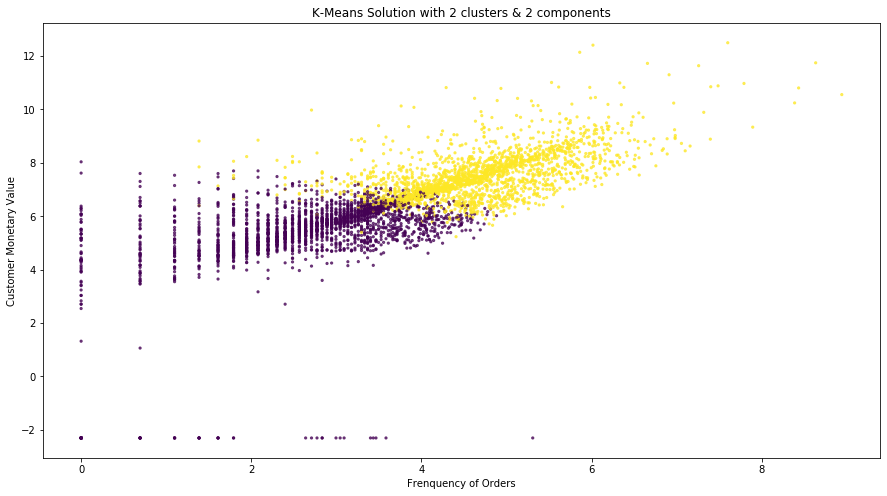

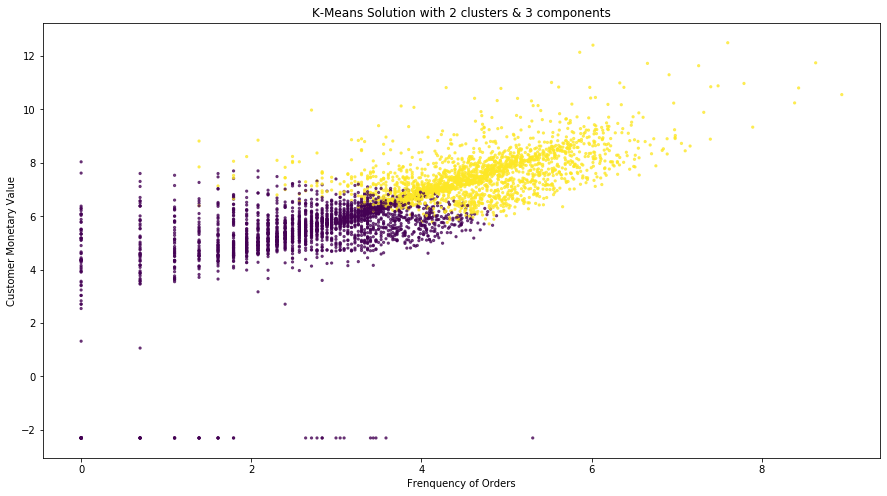

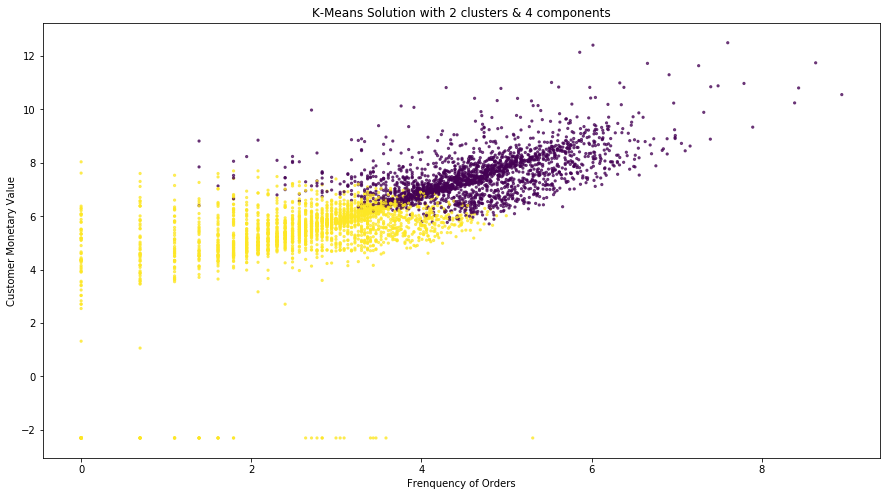

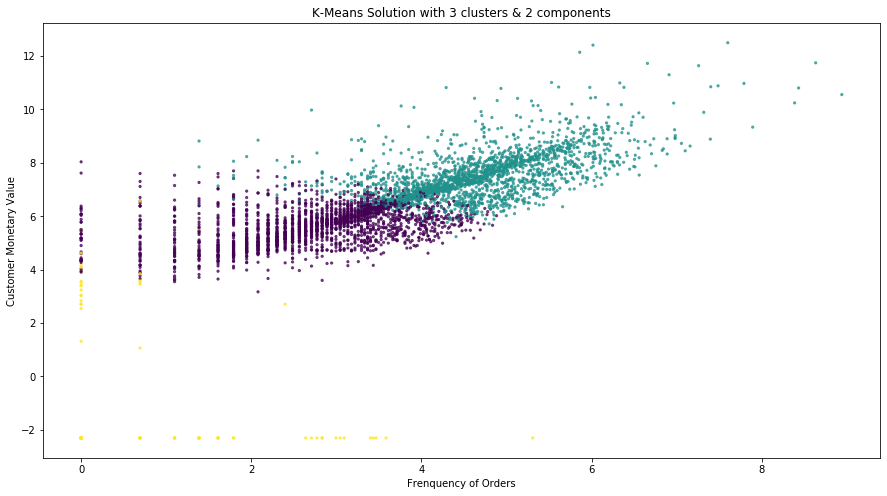

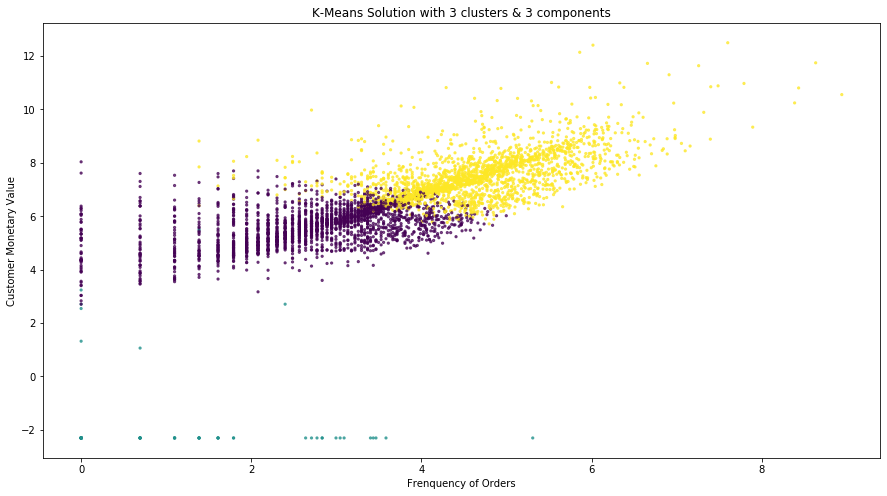

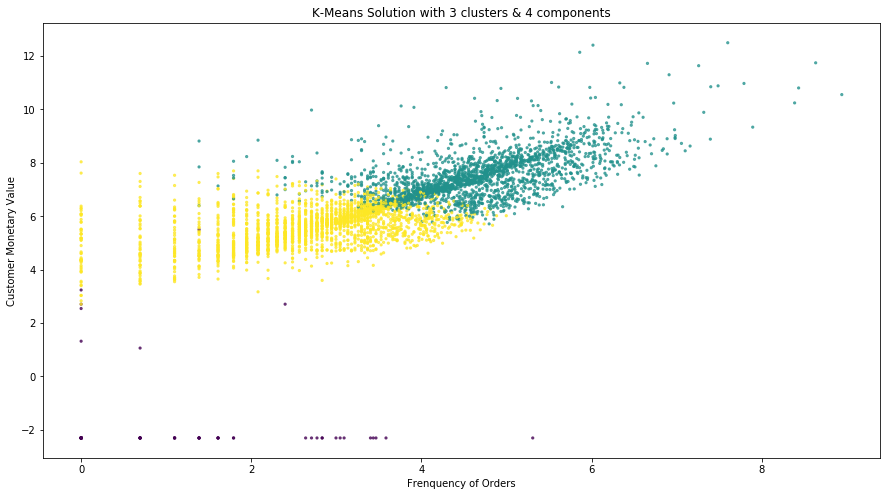

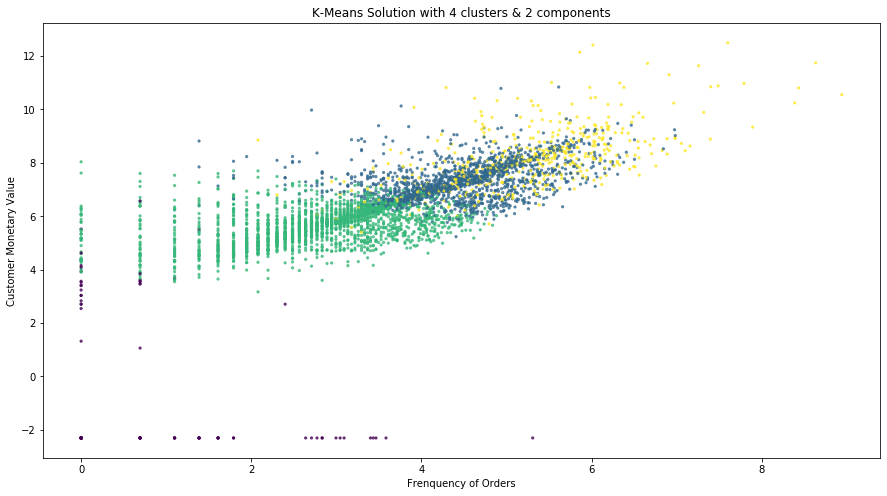

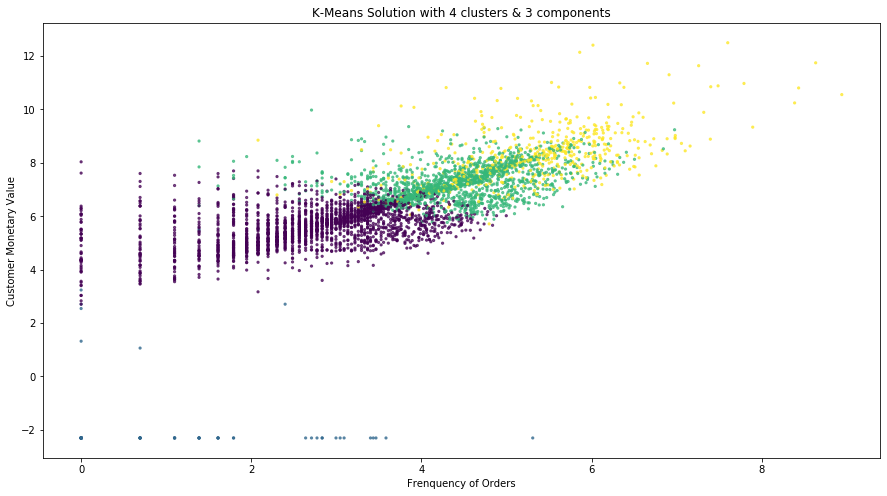

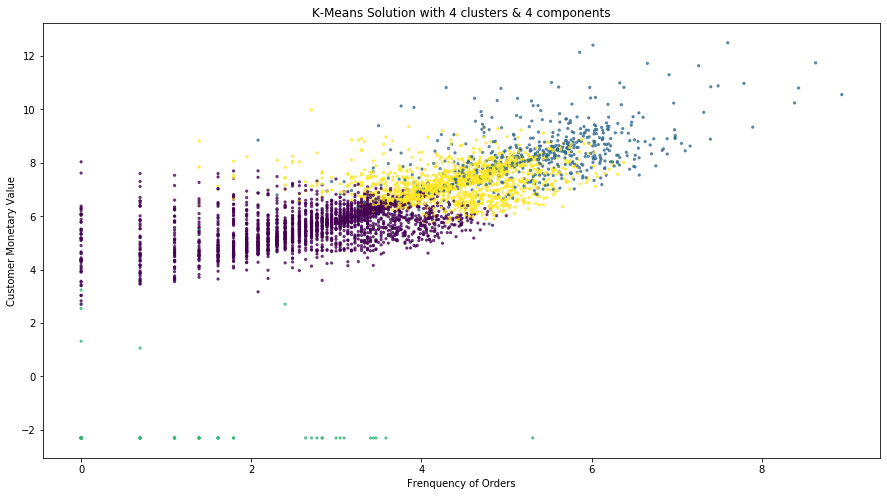

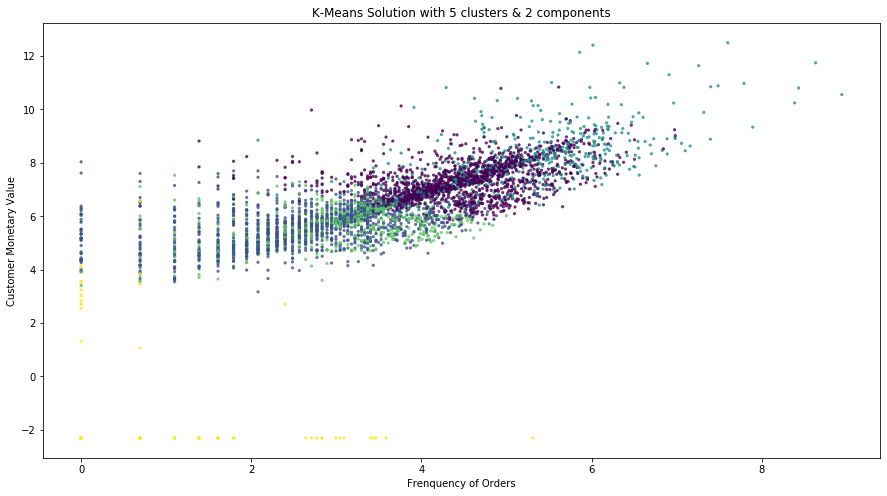

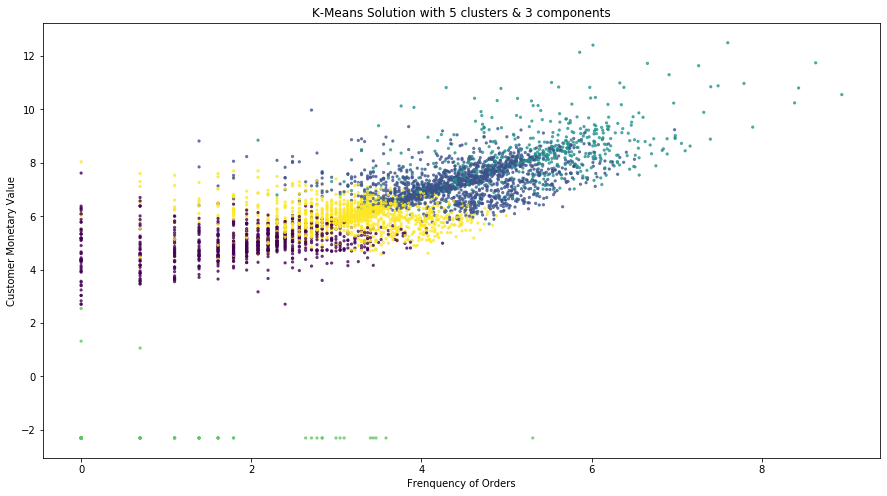

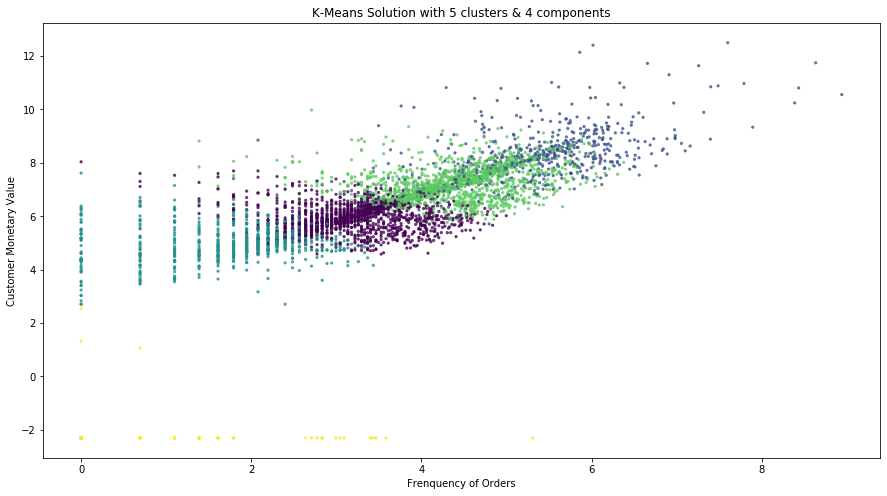

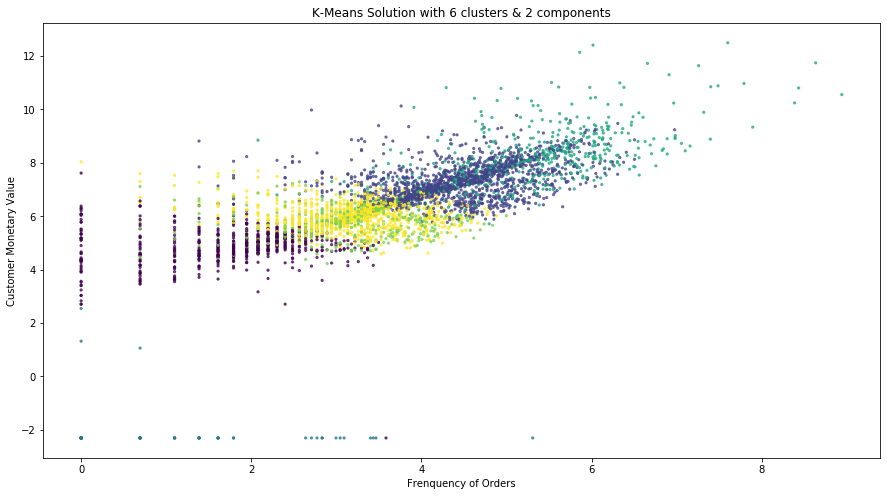

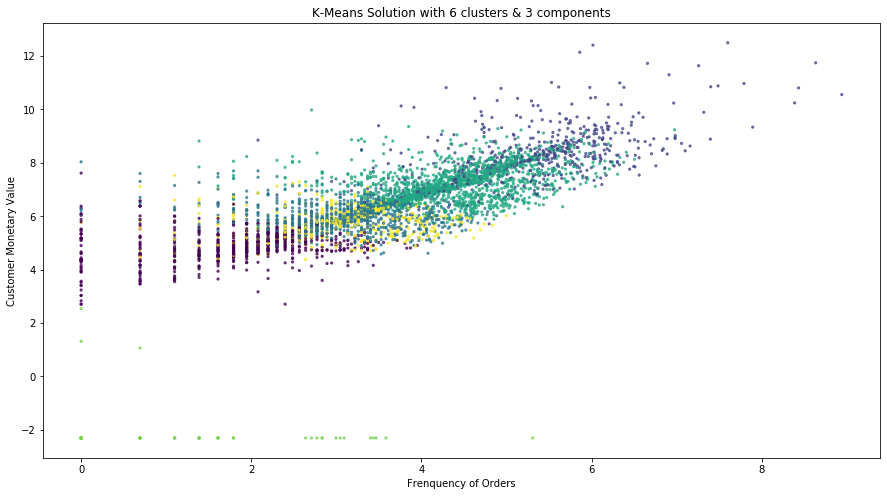

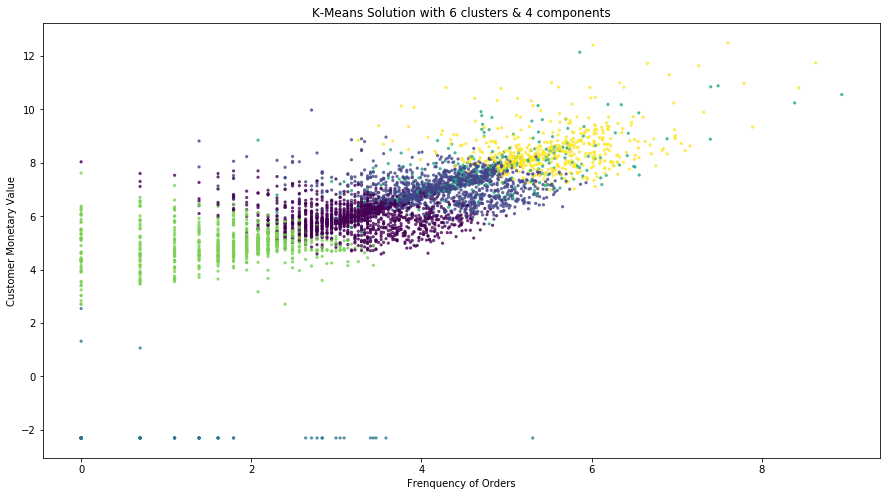

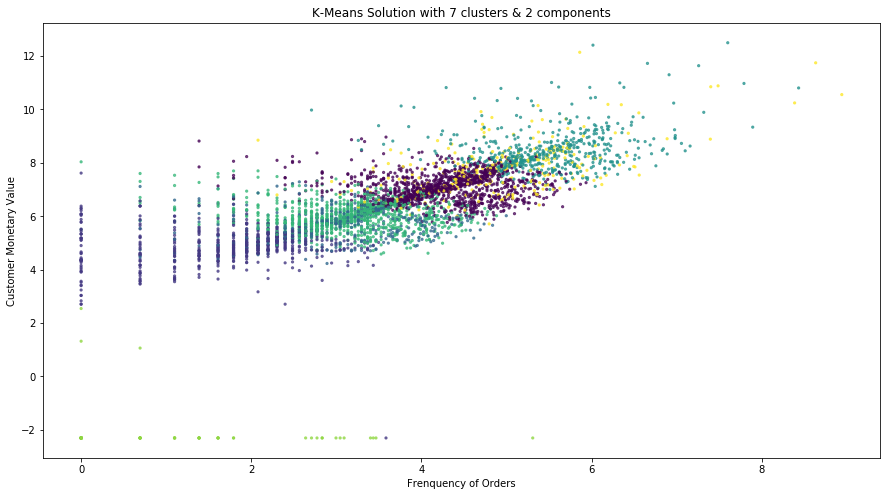

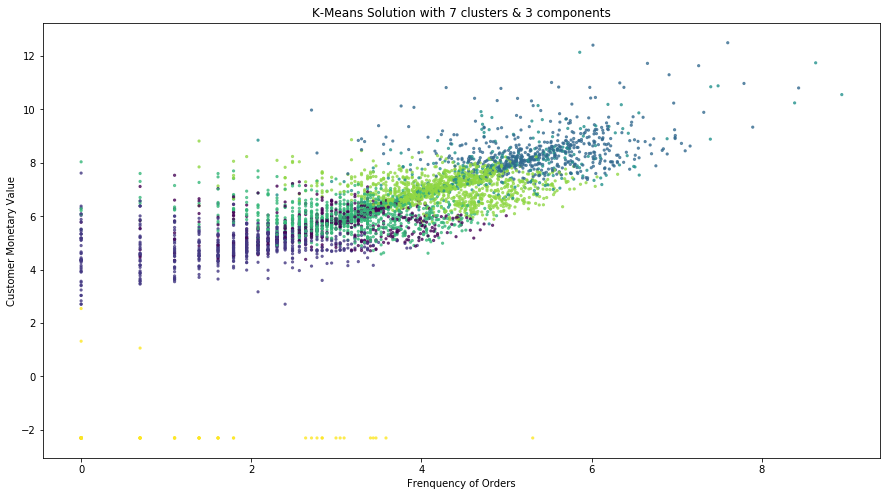

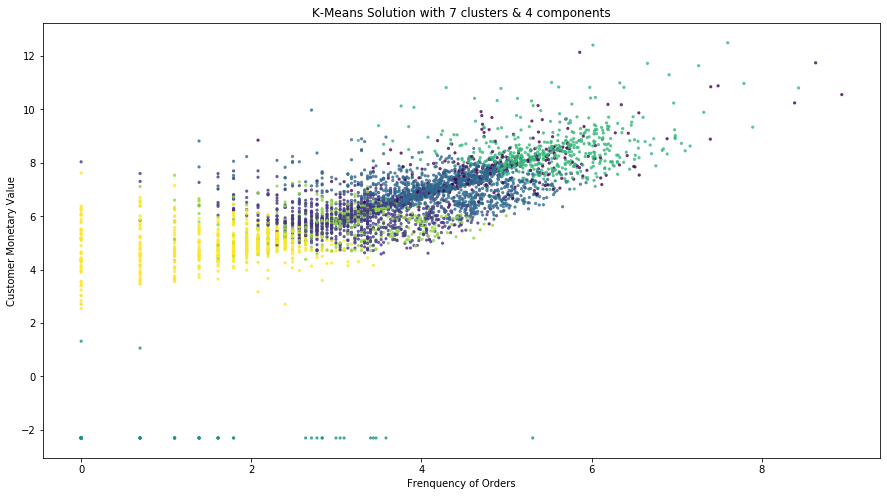

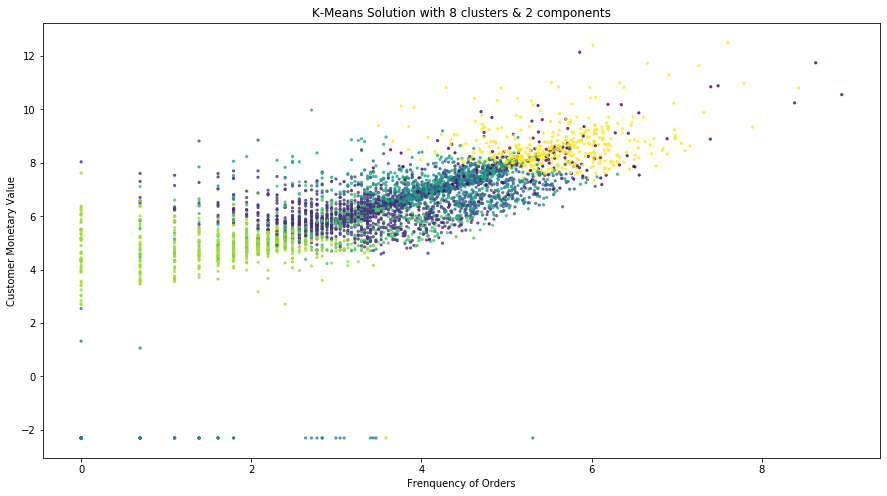

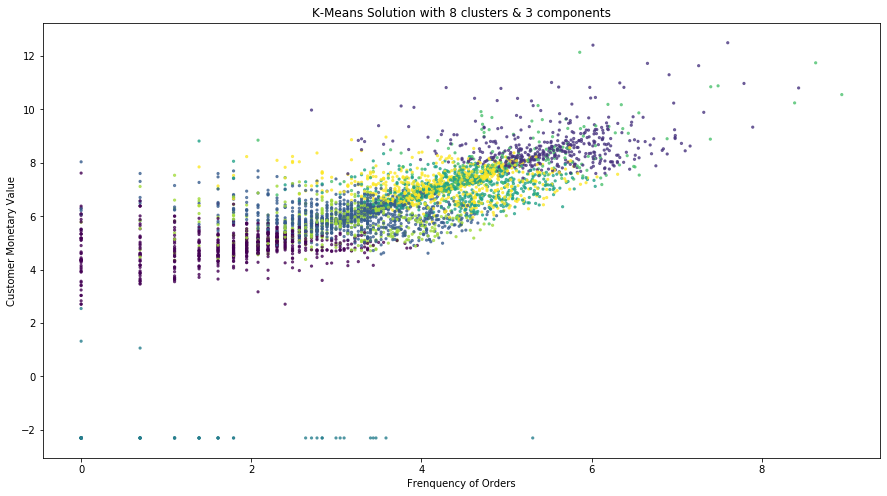

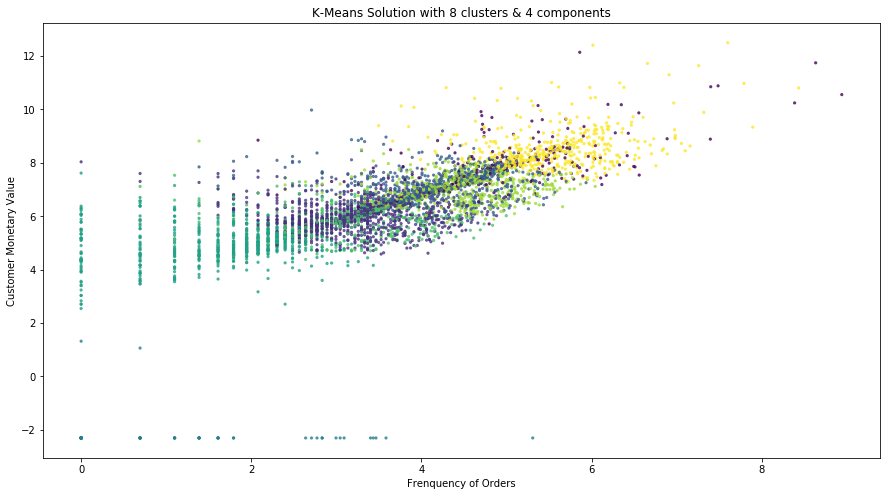

In [65]:
for i in range(2,9):
    for j in range(2,5):

        pipe_kmeans = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=j)),  # change value of c for # of PCA components
                    ('clf', KMeans(n_clusters=i))]) # value of k changes in loop

        pipe_kmeans.fit(log_features)
        cluster_preds = pipe_kmeans.predict(log_features)

        print(f'K-Means Solution with ' + str(i) + ' clusters & ' + str(j) + ' components\n-----------------------')
        print('Calinski-Harabaz (CA) Cluster Variance Ration score: ', calinski_harabasz_score(log_features, cluster_preds))
        print('Cluster Silhouette score: ', metrics.silhouette_score(log_features, cluster_preds))
        print('\n')

        plt.figure(figsize=(15, 8))
        plt.title(f'K-Means Solution with ' + str(i) + ' clusters & ' + str(j) + ' components')
        plt.xlabel("Frenquency of Orders")
        plt.ylabel("Customer Monetary Value")
        plt.scatter(log_features.frequency, log_features.monetary, c=cluster_preds, s=5, alpha=.7)

        # merge cluster predicitons to unlogged, unscaled df and print summary stats by cluster
        customer_df['Cluster'] = cluster_preds
        for cluster in set(cluster_preds):
            print(f'Summary Stats for cluster # {cluster}')
            print(customer_df[customer_df['Cluster'] == cluster][['quantity', 'recency', 'frequency', 'monetary']].describe())
            pop_perc = round((len(customer_df[customer_df['Cluster'] == cluster]) / len(customer_df))*100, 2)
            rev_perc = round((sum(customer_df[customer_df['Cluster'] == cluster].monetary) / sum(customer_df.monetary))*100, 2)               
            total_spend = round(sum(customer_df[customer_df['Cluster'] == cluster].monetary), 2)
            print(f'This cluster represents {pop_perc}% of the population and {rev_perc}% of Total Revenue, with a total spend of £{total_spend}')
            print('\n\n\n')
        current = metrics.silhouette_score(log_features, cluster_preds)
        if current > init_cah:
            final_i = i
            final_j = j
            init_cah = current
        else:
            pass


In [66]:
init_cah

0.3857749401288108

HAC Solution with 2 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2857.6974640493117
Cluster Silhouette score:  0.37363370731778783


Summary Stats for cluster # 0
           quantity      recency    frequency     monetary
count   2258.000000  2258.000000  2258.000000  2258.000000
mean     199.069531   137.170505    22.837910   338.539278
std      330.494412   110.351630    19.474358   286.636347
min     -303.000000     0.000000     1.000000 -4287.630000
25%       85.000000    38.000000     9.000000   167.752500
50%      156.000000   111.000000    18.000000   300.390000
75%      258.000000   230.000000    30.000000   453.007500
max    12540.000000   365.000000   202.000000  3096.000000
This cluster represents 52.1% of the population and 9.55% of Total Revenue, with a total spend of £764421.69




Summary Stats for cluster # 1
            quantity      recency    frequency       monetary
count    2076.000000  2076.000000  2076.0000

HAC Solution with 3 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2414.5915318223724
Cluster Silhouette score:  0.3857749401288108


Summary Stats for cluster # 0
            quantity      recency    frequency       monetary
count    2076.000000  2076.000000  2076.000000    2076.000000
mean     2060.781310    39.167148   163.692678    3485.983011
std      6386.072526    50.204301   303.873436   11272.052128
min       170.000000     0.000000     4.000000     303.090000
25%       573.000000     8.000000    60.000000     995.032500
50%       962.500000    21.000000   101.500000    1616.270000
75%      1784.500000    52.000000   177.000000    3002.537500
max    188761.000000   358.000000  7637.000000  267761.000000
This cluster represents 47.9% of the population and 90.45% of Total Revenue, with a total spend of £7236900.73




Summary Stats for cluster # 1
           quantity      recency    frequency     monetary
count   2207.000000

HAC Solution with 5 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2364.8139918619754
Cluster Silhouette score:  0.27687745038193323


Summary Stats for cluster # 0
          quantity      recency    frequency     monetary
count  1429.000000  1429.000000  1429.000000  1429.000000
mean    260.783065   117.763471    30.473058   447.422883
std     222.589026   104.090553    19.527260   255.903841
min      32.000000     0.000000     1.000000    77.400000
25%     153.000000    27.000000    18.000000   292.470000
50%     220.000000    81.000000    26.000000   384.800000
75%     311.000000   196.000000    38.000000   546.810000
max    4300.000000   365.000000   148.000000  3096.000000
This cluster represents 32.97% of the population and 7.99% of Total Revenue, with a total spend of £639367.3




Summary Stats for cluster # 1
           quantity      recency    frequency      monetary
count   1673.000000  1673.000000  1673.000000   1673.00

HAC Solution with 6 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2373.4366911509396
Cluster Silhouette score:  0.2764224596255309


Summary Stats for cluster # 0
           quantity      recency    frequency      monetary
count   1673.000000  1673.000000  1673.000000   1673.000000
mean    1510.059773    48.224746   133.254035   2483.202756
std     2359.547877    52.003022   128.863502   3645.533812
min      170.000000     3.000000     4.000000    320.720000
25%      556.000000    15.000000    57.000000    954.090000
50%      900.000000    29.000000    95.000000   1516.650000
75%     1596.000000    63.000000   158.000000   2650.730000
max    32592.000000   358.000000  1212.000000  50992.610000
This cluster represents 38.6% of the population and 51.92% of Total Revenue, with a total spend of £4154398.21




Summary Stats for cluster # 1
            quantity     recency    frequency       monetary
count     403.000000  403.000000   

HAC Solution with 6 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2042.5544955965972
Cluster Silhouette score:  0.24088861623724264


Summary Stats for cluster # 0
           quantity      recency    frequency     monetary
count   1632.000000  1632.000000  1632.000000  1632.000000
mean     248.943015   102.620098    27.721814   416.042390
std      375.098455    97.447870    19.885905   259.199262
min        4.000000     0.000000     1.000000     0.000000
25%      134.000000    25.000000    14.000000   249.457500
50%      201.000000    63.000000    23.000000   363.720000
75%      296.500000   165.000000    35.000000   527.752500
max    12540.000000   365.000000   148.000000  3096.000000
This cluster represents 37.66% of the population and 8.49% of Total Revenue, with a total spend of £678981.18




Summary Stats for cluster # 1
           quantity      recency    frequency      monetary
count   1488.000000  1488.000000  1488.000000

HAC Solution with 7 clusters & 3 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2292.292544107471
Cluster Silhouette score:  0.2663642526452674


Summary Stats for cluster # 0
            quantity     recency    frequency       monetary
count     535.000000  535.000000   535.000000     535.000000
mean     5160.186916   36.218692   329.441121    8771.973664
std     11874.305345   45.559062   543.996175   21127.832744
min       820.000000    0.000000     4.000000    1133.070000
25%      1736.000000    9.000000   137.500000    2949.435000
50%      2470.000000   21.000000   216.000000    4098.800000
75%      4292.500000   45.000000   356.500000    6826.435000
max    188761.000000  307.000000  7637.000000  267761.000000
This cluster represents 12.34% of the population and 58.65% of Total Revenue, with a total spend of £4693005.91




Summary Stats for cluster # 1
         quantity     recency   frequency     monetary
count  784.000000  784.000000  7

HAC Solution with 8 clusters & 2 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2183.3332940747746
Cluster Silhouette score:  0.25004093274750316


Summary Stats for cluster # 0
          quantity      recency    frequency     monetary
count  1193.000000  1193.000000  1193.000000  1193.000000
mean    802.620285    50.834032    87.010059  1306.364040
std     527.738879    54.136116    56.436695   700.056223
min     170.000000     4.000000     4.000000   320.720000
25%     488.000000    15.000000    49.000000   814.720000
50%     688.000000    32.000000    73.000000  1141.240000
75%     991.000000    65.000000   108.000000  1624.210000
max    8000.000000   358.000000   421.000000  7092.060000
This cluster represents 27.53% of the population and 19.48% of Total Revenue, with a total spend of £1558492.3




Summary Stats for cluster # 1
           quantity     recency   frequency     monetary
count    778.000000  778.000000  778.000000   778.000000

HAC Solution with 8 clusters & 4 components
-----------------------
Calinski-Harabaz (CA) Cluster Variance Ration score:  2129.5271414400227
Cluster Silhouette score:  0.2317523381509796


Summary Stats for cluster # 0
           quantity     recency   frequency     monetary
count    669.000000  669.000000  669.000000   669.000000
mean     201.327354   25.512706   28.621824   331.514335
std      492.012167   22.765175   21.763127   210.116369
min        4.000000    0.000000    1.000000     0.000000
25%       96.000000    9.000000   12.000000   173.900000
50%      166.000000   20.000000   24.000000   301.290000
75%      246.000000   35.000000   39.000000   428.570000
max    12540.000000  127.000000  148.000000  1873.200000
This cluster represents 15.44% of the population and 2.77% of Total Revenue, with a total spend of £221783.09




Summary Stats for cluster # 1
         quantity     recency   frequency     monetary
count  575.000000  575.000000  575.000000   575.000000
mean    78.318

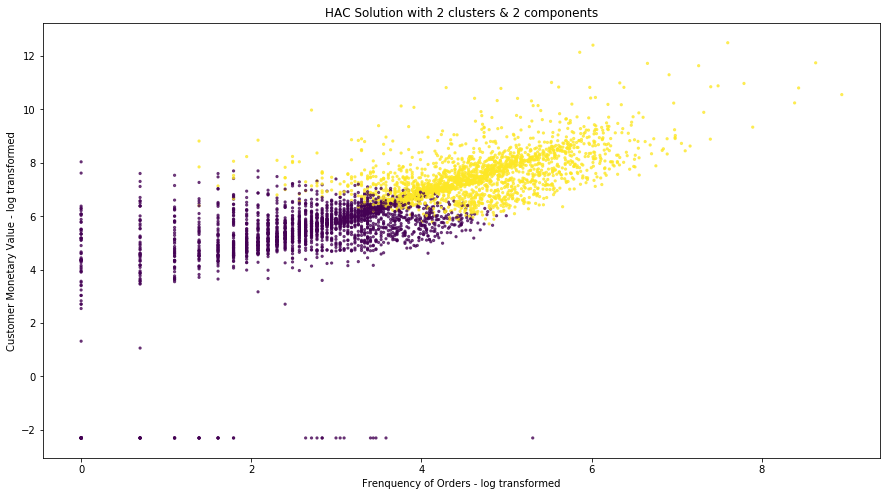

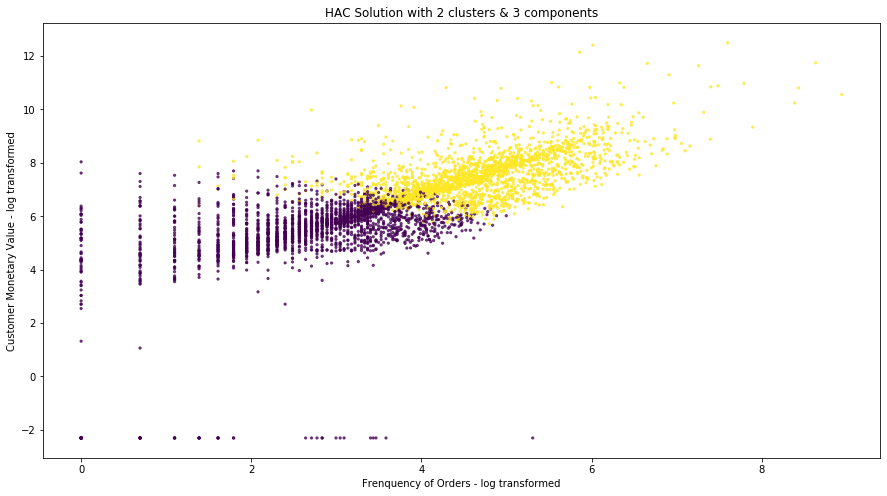

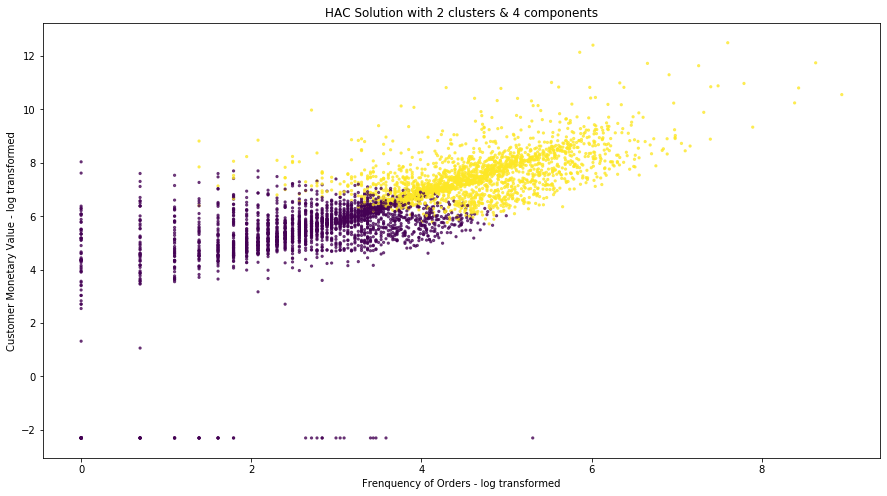

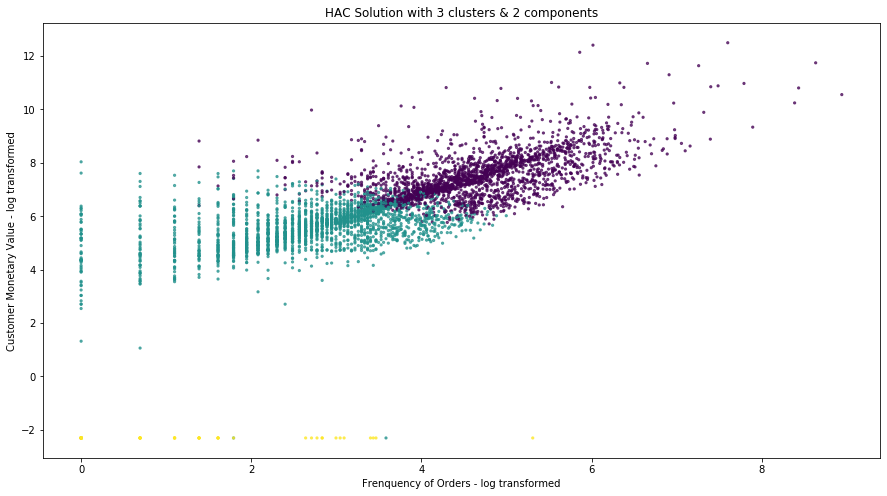

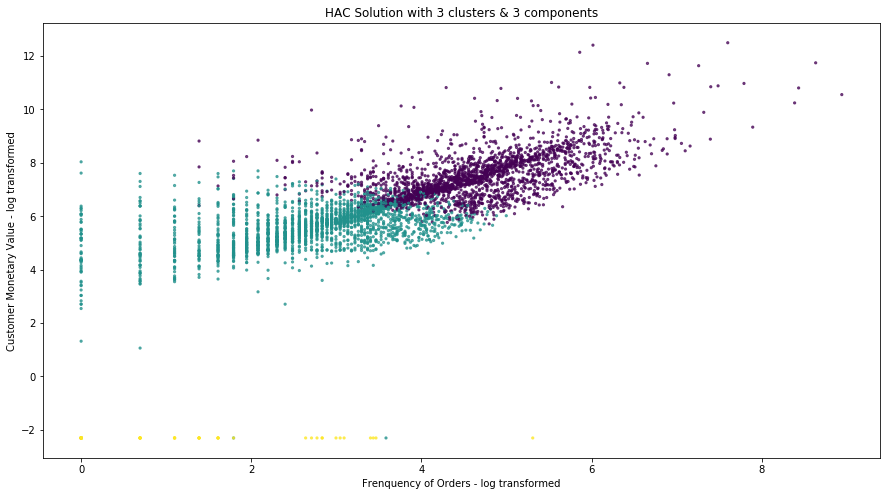

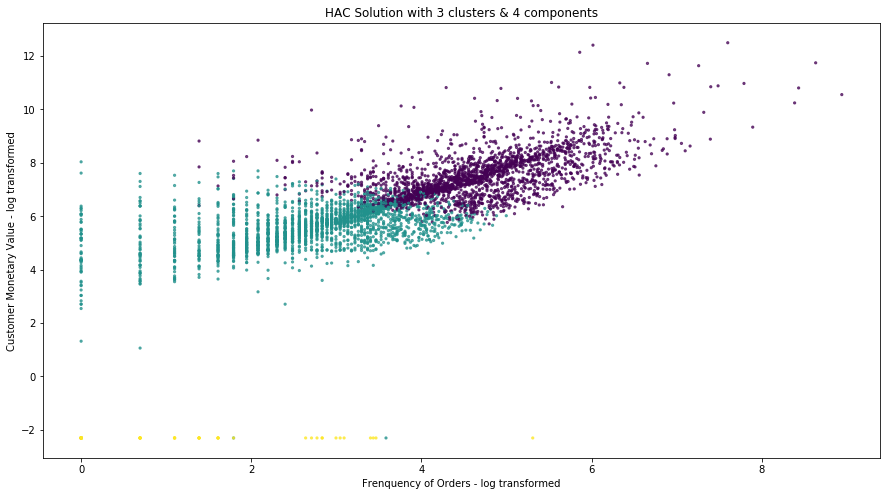

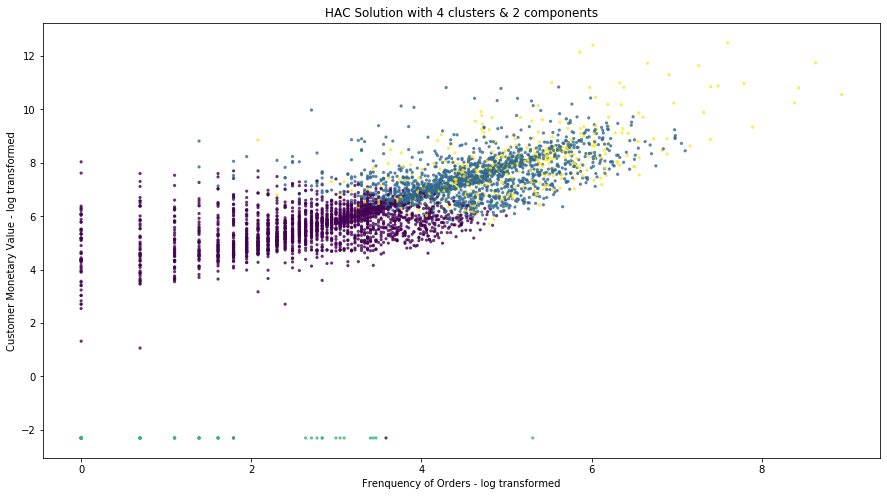

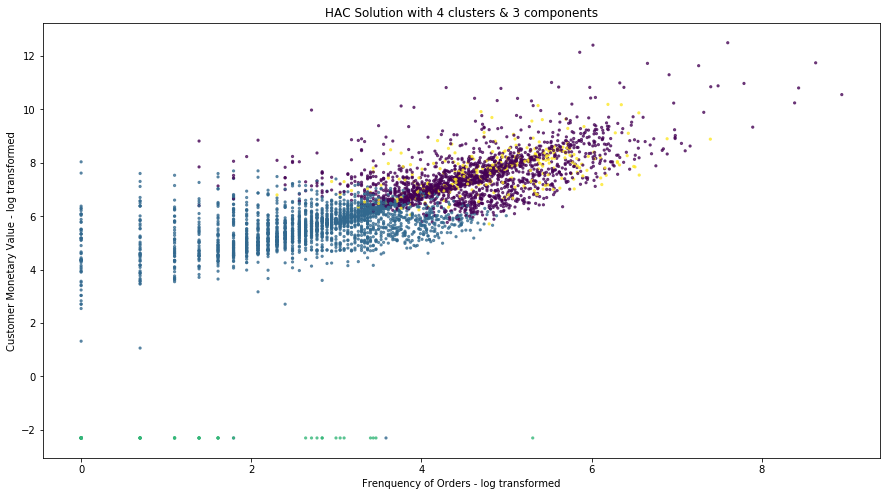

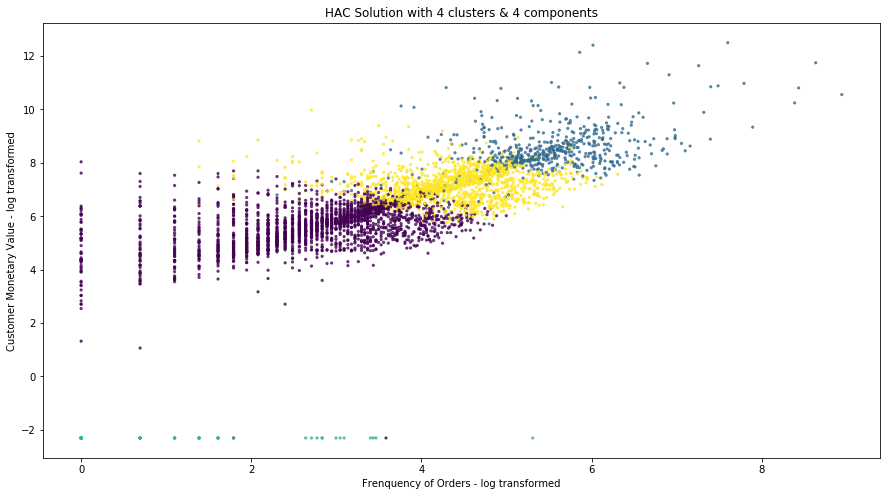

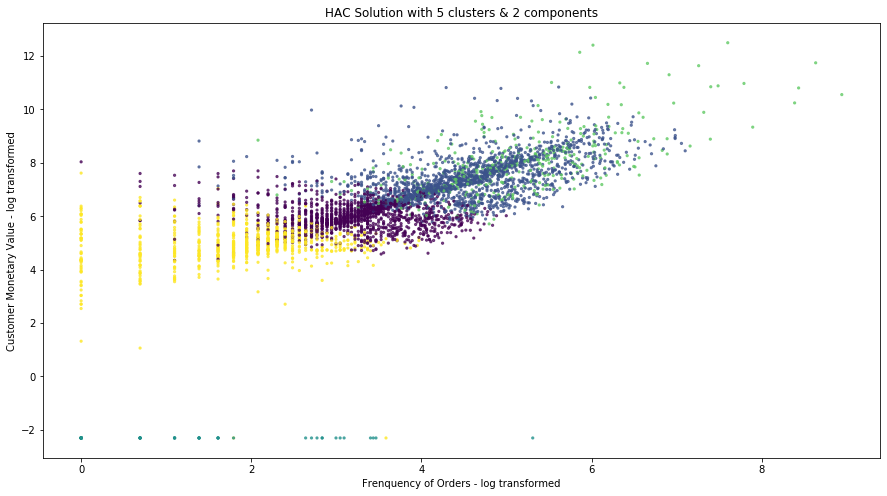

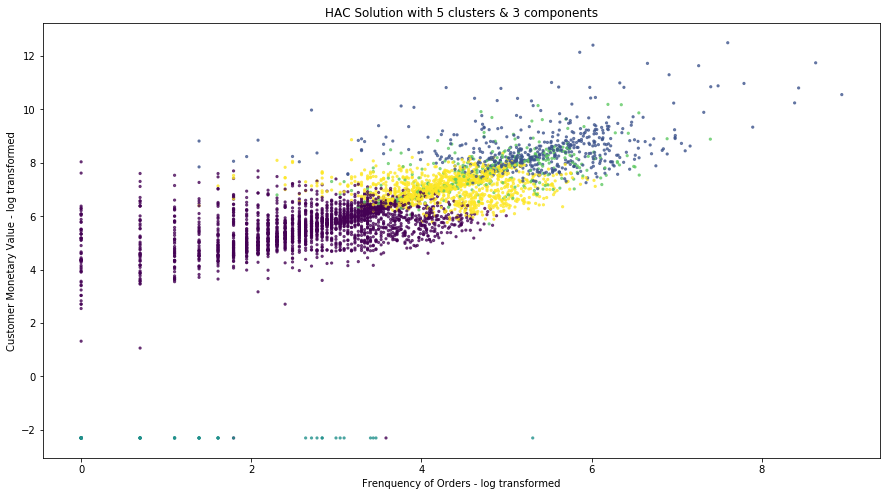

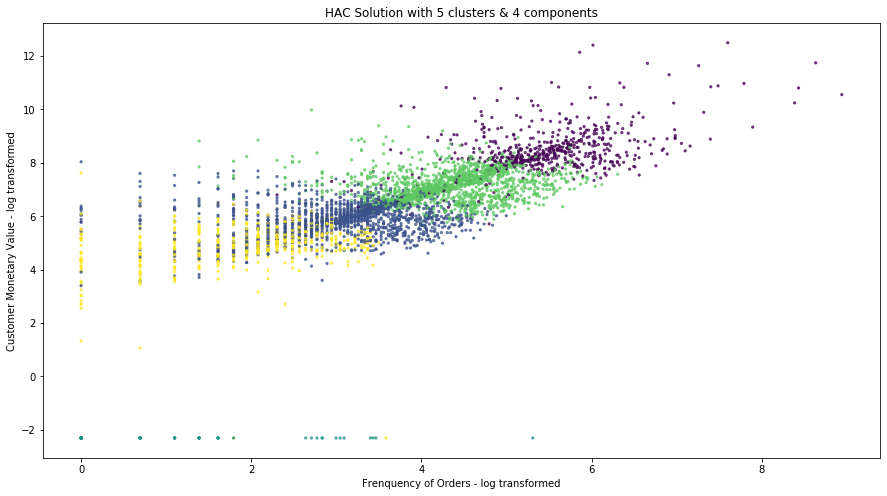

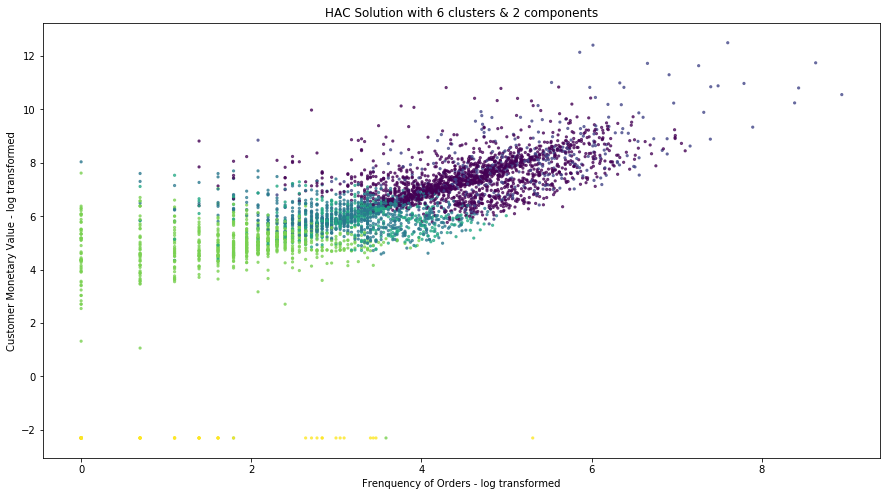

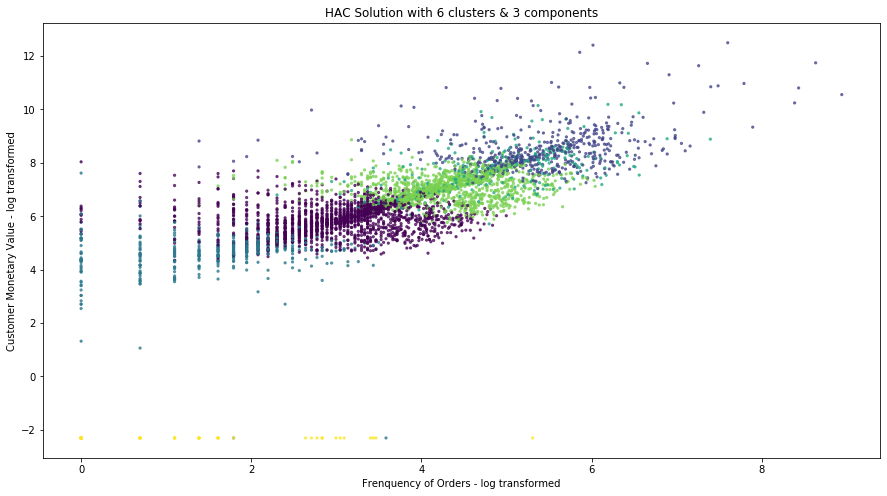

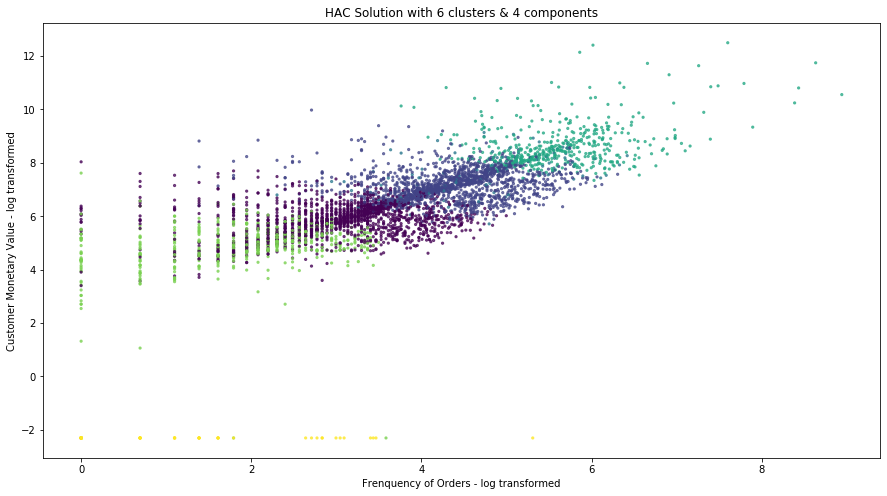

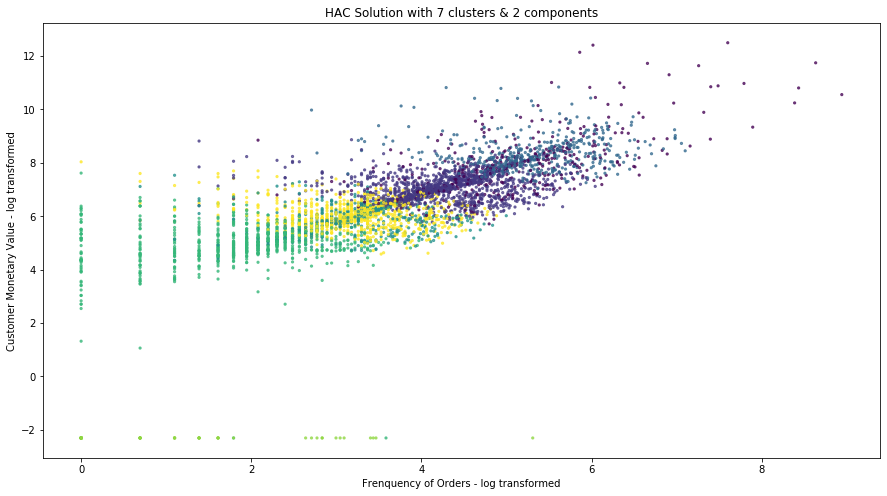

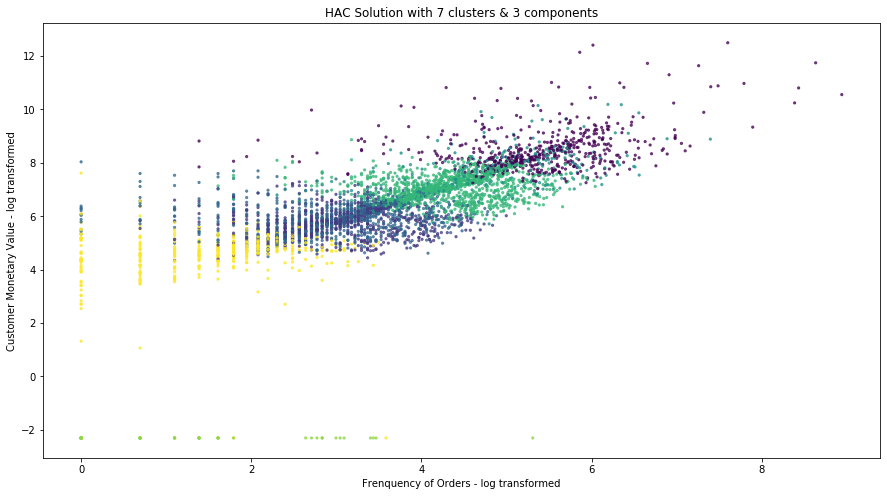

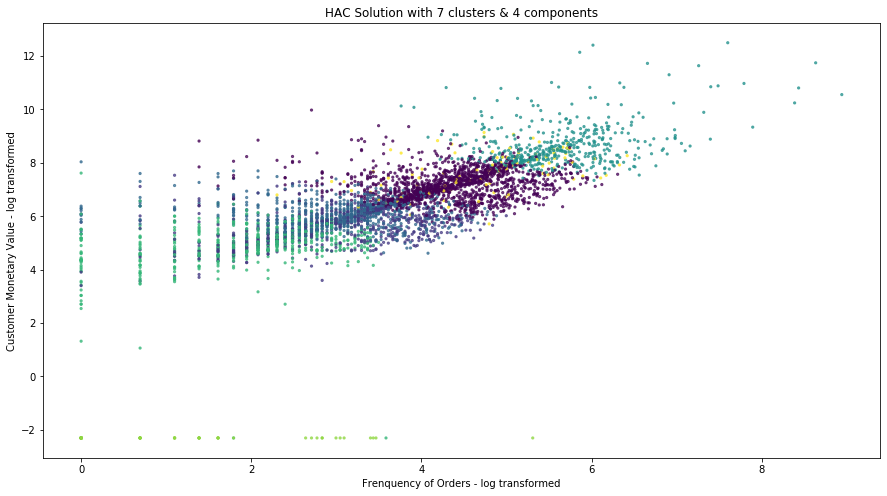

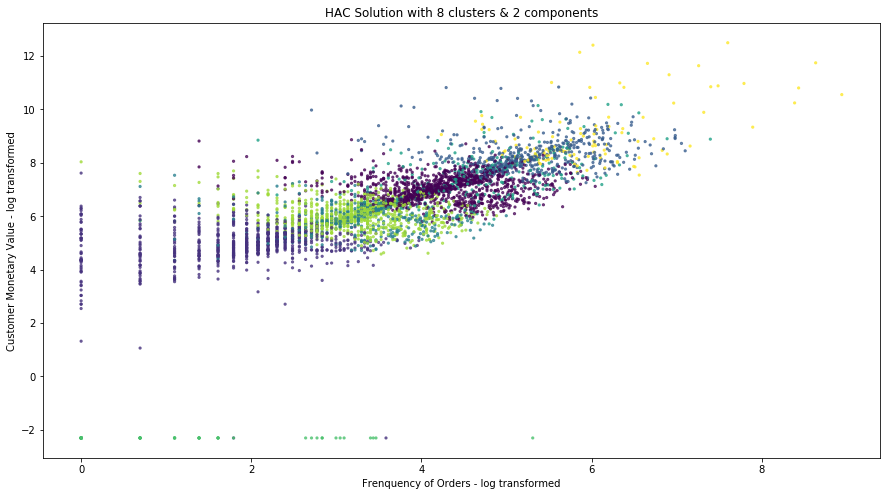

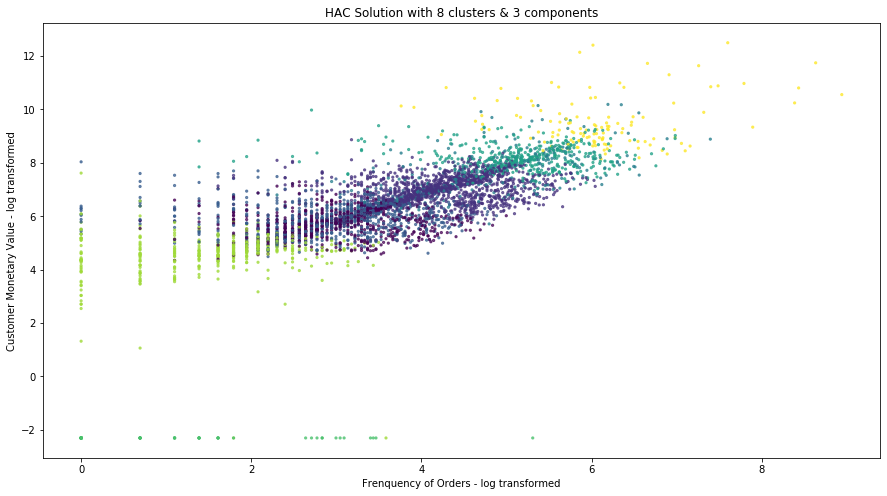

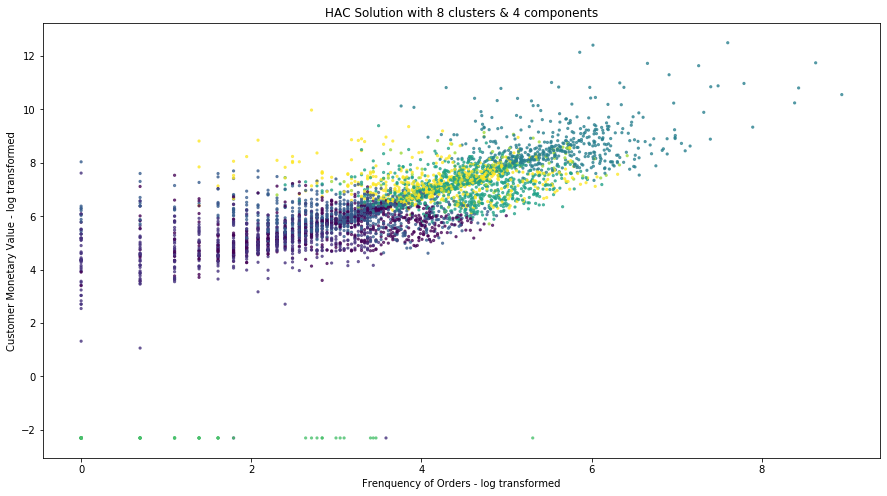

In [55]:
for i in range(2,9):
    for j in range(2,5):

        pipe_HAC = Pipeline([('scl', StandardScaler()),
                    ('pca', PCA(n_components=j)), # see above
                    ('clf', AgglomerativeClustering(n_clusters=i))]) # see above

        pipe_HAC.fit(log_features)
        cluster_preds = pipe_HAC.fit_predict(log_features)

        print(f'HAC Solution with ' + str(i) + ' clusters & ' + str(j) + ' components\n-----------------------')
        print('Calinski-Harabaz (CA) Cluster Variance Ration score: ', calinski_harabasz_score(log_features, cluster_preds))
        print('Cluster Silhouette score: ', metrics.silhouette_score(log_features, cluster_preds))
        print('\n')
        
        current = metrics.silhouette_score(log_features, cluster_preds)
        if current > init_cah:
            final_i = i
            final_j = j
            init_cah = current
        else:
            pass

        plt.figure(figsize=(15, 8))
        plt.title(f'HAC Solution with ' + str(i) + ' clusters & ' + str(j) + ' components')
        plt.xlabel("Frenquency of Orders - log transformed")
        plt.ylabel("Customer Monetary Value - log transformed")
        plt.scatter(log_features.frequency, log_features.monetary, c=cluster_preds, s=5, alpha=.7)

        # merge cluster predicitons to unlogged, unscaled df and print summary stats by cluster
        customer_df['Cluster'] = cluster_preds
        for cluster in set(cluster_preds):
            print(f'Summary Stats for cluster # {cluster}')
            print(customer_df[customer_df['Cluster'] == cluster][['quantity', 'recency', 'frequency', 'monetary']].describe())
            pop_perc = round((len(customer_df[customer_df['Cluster'] == cluster]) / len(customer_df))*100, 2)
            rev_perc = round((sum(customer_df[customer_df['Cluster'] == cluster].monetary) / sum(customer_df.monetary))*100, 2)               
            total_spend = round(sum(customer_df[customer_df['Cluster'] == cluster].monetary), 2)
            print(f'This cluster represents {pop_perc}% of the population and {rev_perc}% of Total Revenue, with a total spend of £{total_spend}')
            print('\n\n\n')

In [56]:
final_i

0

In [57]:
final_j

0

In [58]:
current

0.2317523381509796

In [59]:
init_cah

0.3857749401288108